# Exploratory data analysis

In [83]:
import pandas as pd  
import numpy as np
import warnings 
import math
warnings.simplefilter('ignore')
import sklearn 
import seaborn as sns
sns.set(context='paper', style='whitegrid',
        rc={'figure.facecolor':'white',
           'figure.figsize': (10,6)}, 
        font_scale=1.2)

import matplotlib.pyplot as plt

# import custom functions
import sys
sys.path.append("../")
import mcc_metastasis.data_cleaning as dc


In [192]:
# plotting func
def density_by_mets(xmax, var, var_label, figurepath):

    plt.figure(figsize = (8,6))
    outcomes = [0,1]
    for value in outcomes:
    # Subset to the airline
        subset = df[df.TNM_positive == value]
    
    # Draw the density plot
        sns.distplot(subset[var], hist = False, kde = True,
                 kde_kws = {'shade' :True, 'linewidth': 2},
                 label = value)
    
# Plot formatting
    legend = plt.legend(prop={'size': 15}, title = 'Metastasis')
    legend.get_title().set_fontsize('15')
    plt.xlabel(var_label, size = 15)
    plt.ylabel('Density', size = 15)
    plt.xlim(0, xmax)
    plt.savefig(figurepath, bbox_inches = 'tight')
    plt.show()
    
def barplot_by_mets(height, aspect, var, var_label, figurepath):
    
    g = sns.catplot(data = df, x = var , 
                    kind = "count",
                     hue = "TNM_positive",
                     height = height, aspect =aspect ,
                    legend = False)
    plt.xlabel(var_label, size =  20)
    plt.ylabel ("Count",  size = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 12)
    legend = plt.legend(prop={'size': 15}, title = 'Metastasis')
    legend.get_title().set_fontsize('15')
    plt.savefig(figurepath, bbox_inches = 'tight')


## open data
### 1. NCDB with full feature set
- exploring all available features .... and comparing both outcomes

In [170]:
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv")
# select only features for analysis
df = df[[ 'metastasis', 'TNM_positive', 'AGE', 'tumor_size', 'tumor_site', 'SEX', 
          'immuno_suppressed', 'tumor_depth',
           'tumor_lymphocytes', 'lymph_vasc_invasion', 'growth_pattern']]
df_complete = df.dropna(axis = 0)
df.head()

,metastasis,TNM_positive,AGE,tumor_size,tumor_site,SEX,immuno_suppressed,tumor_depth,tumor_lymphocytes,lymph_vasc_invasion,growth_pattern
0,NaN,NaN,90,NaN,trunk,0,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,71,1.0,head_neck,1,NaN,NaN,NaN,0.0,NaN
2,1.0,NaN,87,NaN,extremity,1,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,43,0.2,other,1,0.0,0.1,0.0,NaN,NaN
4,NaN,NaN,81,NaN,other,1,NaN,NaN,NaN,NaN,NaN


In [171]:
print("Number of  records: {}".format(df.shape[0]))
print("Number of complete records: {}".format(df_complete.shape[0]))

print("Number of variables: {}".format(df.shape[1]))

Number of  records: 14948
Number of complete records: 419
Number of variables: 11


## Compare outcome variables 
### with full dataset
- TNM positive is missing 3403 cases that are positive in metastasis variable
- huge difference in the ratio of positive to negative between variables.

In [172]:
# TNM is missing 3K values that we do have for mets
dc.get_N_table(df, ['metastasis', 'TNM_positive'])

,metastasis,TNM_positive,N
0,0.0,0.0,4366
1,0.0,1.0,2
2,0.0,NaN,2874
3,1.0,0.0,28
4,1.0,1.0,1140
5,1.0,NaN,2966
6,NaN,0.0,649
7,NaN,1.0,16
8,NaN,NaN,2907


In [173]:
display(dc.get_N_table(df, ['metastasis']))
display(dc.get_N_table(df, ['TNM_positive']))

,metastasis,N
0,0.0,7242
1,1.0,4134
2,NaN,3572


,TNM_positive,N
0,0.0,5043
1,1.0,1158
2,NaN,8747


### with complete dataset
- mostly 99% match

In [174]:
dc.get_N_table(df_complete, ['metastasis', 'TNM_positive'])

,metastasis,TNM_positive,N
0,0.0,0.0,286
1,0.0,1.0,1
2,1.0,0.0,2
3,1.0,1.0,130


## Basic Tumor features

### Location of the tumor

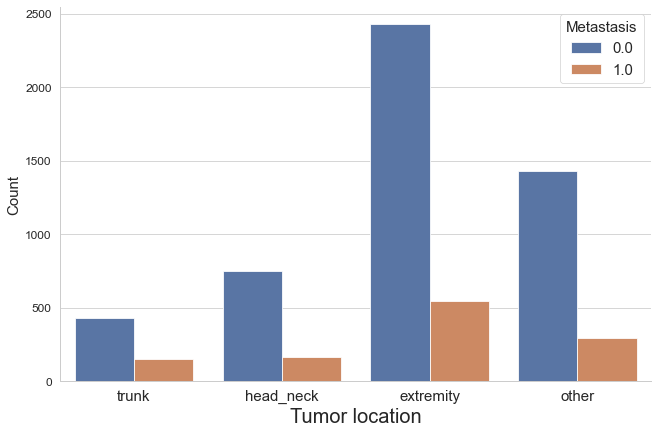

In [178]:

barplot_by_mets( 6, 1.5, 'tumor_site', 'Tumor location',
                 '../figures/EDA/TNM_positive_tumor_location.png')

### Tumor size
- note, could be provided as exact value or in 1 cm bins

In [131]:
# how much of the data is just by bin, not exact value?
N_bins = sum((df.tumor_size == 1) | (df.tumor_size == 2) |
    (df.tumor_size == 3.0) | (df.tumor_size == 4.0) |
      (df.tumor_size == 5.0) | (df.tumor_size == 6.0))

prop_bins = N_bins / sum(df.tumor_size.notnull())
print("Proportion of tumor size data provided in 1 cm bins: %0.2f" % prop_bins)


Proportion of tumor size data provided in 1 cm bins: 0.29


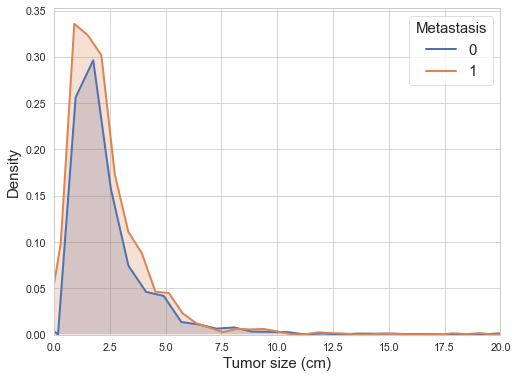

In [195]:
density_by_mets(20,'tumor_size', 'Tumor size (cm)', 
            '../figures/EDA/tumor_size_TNM_positive.png')

### tumor depth

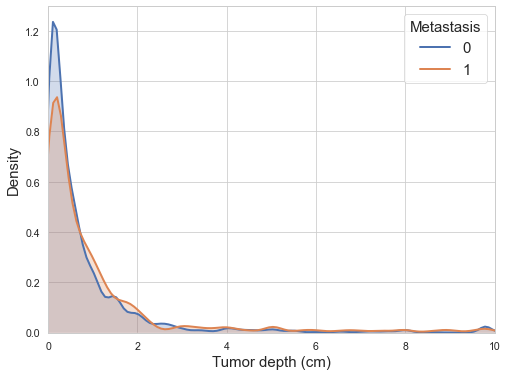

In [194]:
density_by_mets(10, 'tumor_depth', 'Tumor depth (cm)', 
                '../figures/EDA/tumor_depth_TNM_positive.png')

In [138]:
df.tumor_depth[df.tumor_depth.notnull()].min()

0.01

### correlation between depth and size 
- they are correlated, and tumor size is always reported, so we'll use that.

In [139]:
from scipy.stats import pearsonr
pearsonr(df_complete.tumor_size, df_complete.tumor_depth)

(0.1693777394850564, 0.0004978536773582519)

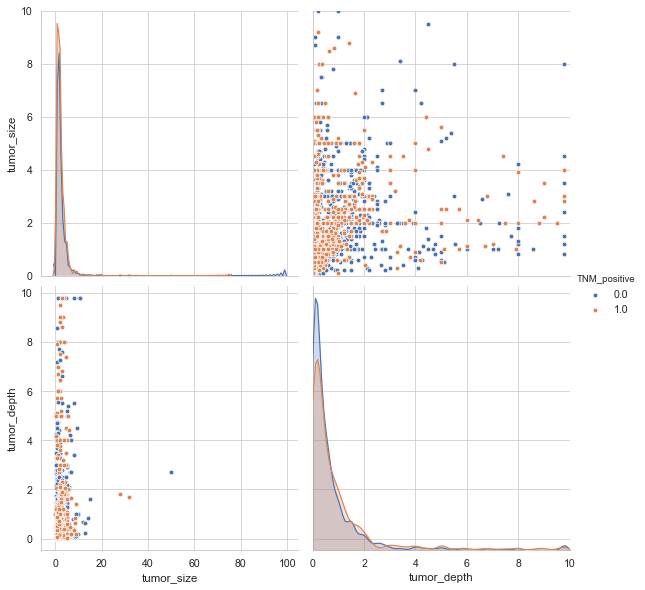

In [67]:
g = sns.pairplot(data = df[['tumor_size', 'tumor_depth', 'TNM_positive']],
             hue = "TNM_positive",  height = 4)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.savefig('../figures/EDA/tumor_size_vs_dept_TNM_positive.png', bbox_inches = 'tight')


## Histologic features

### Lymphnode vascular invasion
Indicates the presence or absence of tumor cells in lymphatic channels (not lymph nodes) or blood vessels within the primary tumor as noted microscopically by the pathologist.

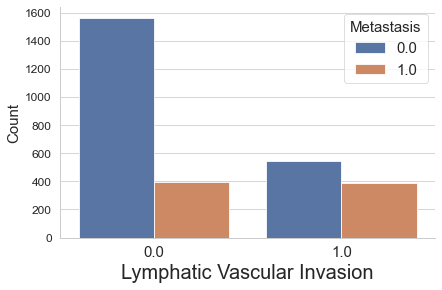

In [186]:
barplot_by_mets(4, 1.5, 'lymph_vasc_invasion', "Lymphatic Vascular Invasion",
               '../figures/EDA/tumor_lymph_vasc_invasion_TNM_positive.png')


### Tumor infiltrating lymphocytes

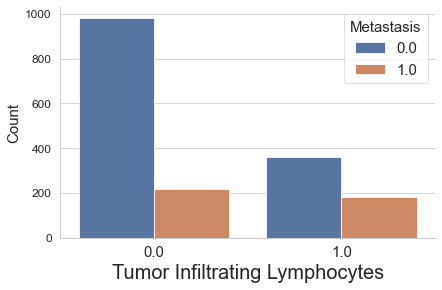

In [185]:
barplot_by_mets(4, 1.5, 'tumor_lymphocytes', 'Tumor Infiltrating Lymphocytes',
                '../figures/EDA/tumor_lymphocytes_TNM_positive.png')


### Tumor growth pattern 
- infiltrative or circum

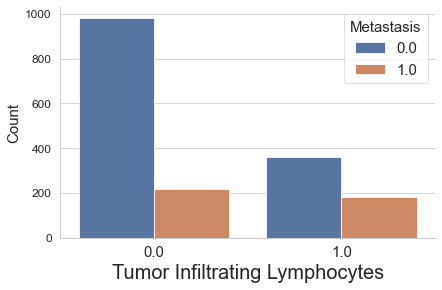

In [182]:
barplot_by_mets(4, 1.5, 'tumor_lymphocytes', 'Tumor Infiltrating Lymphocytes',
                '../figures/EDA/growth_pattern_TNM_positive.png')


##  Immunosuppressed
- didn't end up including
e.g. HIV/AIDS, leukemia, lymphoma


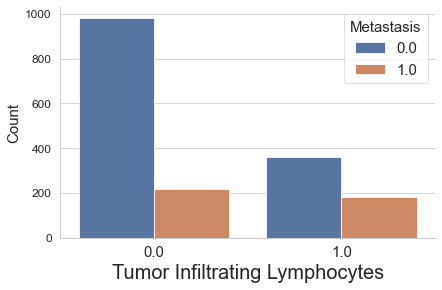

In [183]:
barplot_by_mets(4, 1.5, 'tumor_lymphocytes', 'Tumor Infiltrating Lymphocytes',
                '../figures/EDA/immuno_suppression_TNM_positive.png')


## Demographics 

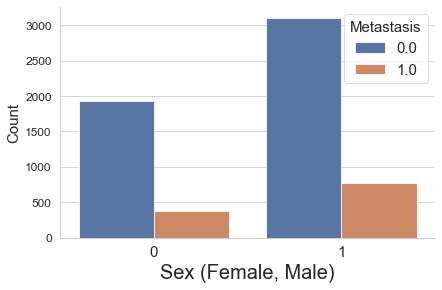

In [187]:
barplot_by_mets(4, 1.5, 'SEX', 'Sex (Female, Male)',
              '../figures/EDA/sex_and_TNM_positive.png')

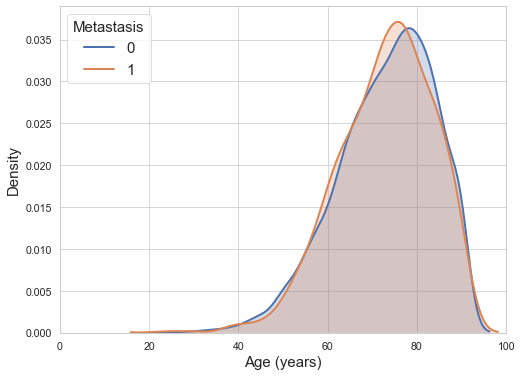

In [196]:
density_by_mets(100, 'AGE', 'Age (years)', "../figures/EDA/age_distrib.png")

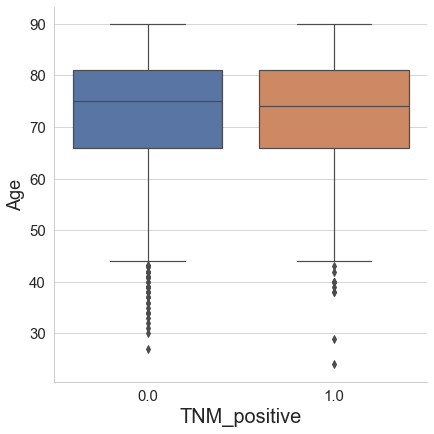

In [97]:
g= sns.catplot(data = df,
                     x = "TNM_positive", y = "AGE", kind = "box",
                      height = 6)
plt.xlabel("TNM_positive", size =  20)
plt.ylabel ("Age",  size = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('../figures/age_and_TNM_positive.png', bbox_inches = 'tight')
